#### Qlunc tutorial by Francisco Costa
# **Tutorial 1**
## Qlunc step by step

This tutorial aims to facilitate the introduction to QLunc. 
Will go through the code and create a lidar device with its modules and components. Will ask for uncertainties either lidar general one or component specific uncertainty. We will see some graphical interesting results. Will see how to access design lidar data.

**Missing here: steps downloading the repository and the first steps, CPU requirements, software versions...**

Importing some packages is always needed:

In [1]:
import pandas as pd
import sys,inspect
from functools import reduce
from operator import getitem
import yaml
import os
import sys
import yaml

### Qlunc inputs:  

A [.yml template](https://github.com/PacoCosta/Qlunc/blob/Qlunc-V0.9/Main/Template_yaml_inputs_file.yml) is included in the repository. To accomplish this tutorial a yaml file is already filled. 

The code below imports the `yaml` file.

In [2]:
# Obtain data from .yaml file:
  
with open (r'./yaml_inputs_file_1.yml','r') as file:
    Qlunc_yaml_inputs={}
    docs = yaml.load_all(file, Loader=yaml.FullLoader)
    for doc in docs:      
        for k, v in doc.items():     
            Qlunc_yaml_inputs.setdefault(k,v)

We obtain a dictionary, a well-known python object, with all the data introduced in the `yaml` file. Let´s have a look to the data:

In [3]:
Qlunc_yaml_inputs

{'Main_directory': '../TestFiles_Qlunc',
 'Components': {'Scanner': {'Name': 'Scanner_Yaml',
   'Origin': [0, 0, 0],
   'Sample rate': 0,
   'Focus distance': [35],
   'Cone angle': [20],
   'Azimuth': [0, 360, 8],
   'stdv focus distance': 1,
   'stdv Cone angle': 0.6,
   'stdv Azimuth': 0.8,
   'Uncertainty function': 'uopc.UQ_Scanner'},
  'Optical Circulator': {'Name': 'OC_Yaml',
   'Insertion loss': 2.1,
   'Uncertainty function': 'uopc.UQ_OpticalCirculator'},
  'Optical Amplifier': {'Name': 'OA_Yaml',
   'Optical amplifier noise figure': '../metadata/NoiseFigure.csv',
   'Optical amplifier gain': 30,
   'Uncertainty function': 'uphc.UQ_Optical_amplifier'},
  'Photodetector': {'Name': 'Photodetector_YAML',
   'Photodetector BandWidth': 380000000.0,
   'Load resistor': 50,
   'Photodetector efficiency': 0.85,
   'Dark current': 5e-09,
   'Photodetector signalP': 0.001,
   'Power interval': [0, 1000, 0.001],
   'Gain TIA': 5000.0,
   'V Noise TIA': 0.00016,
   'Uncertainty function':

Now we have the component inputs, let's create them.

### **Creating the lidar classes**:

We create the python classes by running the Qlunc Core: `Qlunc_Classes.py`

In [4]:
# Execute Qlunc_Classes.py (creating classes for lidar 'objects'):
exec(open(Qlunc_yaml_inputs['Main_directory']+'/WorkingExample_Qlunc_Classes.py').read())
#exec(open('C:/Users/fcosta/SWE_LOCAL/GitHub_Qlunc/TestFiles_Qlunc'+'/WorkingExample_Qlunc_Classes.py').read())

In [5]:
Qlunc_yaml_inputs['Main_directory']+'/WorkingExample_Qlunc_Classes.py'

'../TestFiles_Qlunc/WorkingExample_Qlunc_Classes.py'

The main directory is taken from the yaml file, as well as the rest of the lidar parameters, including plotting flags which select what we want to plot:

In [6]:
# Pointing accuracy uncertainty
flags.flag_plot_pointing_accuracy_unc    = Qlunc_yaml_inputs['Flags']['Pointing accuracy uncertainty']  
# Pattern of measuring points
flags.flag_plot_measuring_points_pattern = Qlunc_yaml_inputs['Flags']['Scanning Pattern']
# Photodetector noise: shot noise, dark current noise, thermal noise as a function of the photodetector input signal power.
flags.flag_plot_photodetector_noise      = Qlunc_yaml_inputs['Flags']['Photodetector noise']

### **Creating the lidar digital twin**:

We can now begin building up the lidar device and we will do it modularly. 
#### Scanner digital twin:
Will begin with the optics module and want to include in here two components: a scanner and an optical circulator, wich characteristics has been introduced in the yaml file.

Then, we can instance the class _scanner_ and the class _optical_circulator_ to build up an _optics_module_, wich at the same time is created by instantiating the class _optics_module_.

Let's instantiate the class _scanner_ to "create" the scanner object:

In [7]:
# Instantiating scanner class to create a Scanner virtual-twin

Scanner1 = scanner(name           = Qlunc_yaml_inputs['Components']['Scanner']['Name'],           
               origin            = Qlunc_yaml_inputs['Components']['Scanner']['Origin'],         
               sample_rate       = Qlunc_yaml_inputs['Components']['Scanner']['Sample rate'],    
               focus_dist        = np.array(Qlunc_yaml_inputs['Components']['Scanner']['Focus distance']*int(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1]/Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][2])),                                       
               cone_angle        = np.array(Qlunc_yaml_inputs['Components']['Scanner']['Cone angle']*int(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1]/Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][2])),
               azimuth           = np.array(np.arange(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0],
                                                    Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1],
                                                    Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][2])),                           
               stdv_focus_dist   = Qlunc_yaml_inputs['Components']['Scanner']['stdv focus distance'],                
               stdv_cone_angle   = Qlunc_yaml_inputs['Components']['Scanner']['stdv Cone angle'],       
               stdv_azimuth      = Qlunc_yaml_inputs['Components']['Scanner']['stdv Azimuth'],
               unc_func          = eval(Qlunc_yaml_inputs['Components']['Scanner']['Uncertainty function']) ) 

Created new scanner: Scanner_Yaml


The label "Yaml" in the name of the device informs us that the data was taken from a yaml file and not manually instantiating the class in question.

#### Optical circulator digital twin:
Then we can create the optical circulator by instantiating the optical_circulator class as follows:

In [8]:
#Optical Circulator:

Optical_circulator = optical_circulator (name           = Qlunc_yaml_inputs['Components']['Optical Circulator']['Name'],
                                         insertion_loss = Qlunc_yaml_inputs['Components']['Optical Circulator']['Insertion loss'],              
                                         unc_func       = eval(Qlunc_yaml_inputs['Components']['Optical Circulator']['Uncertainty function']))  

Created new optical circulator: OC_Yaml


#### Optics module digital twin: 
Then we create the optics module by puting all optic components created so far (_Scanner_ and _Optical_circulator_) together

In [9]:
# Optics Module:

Optics_Module1 =  optics (name               = Qlunc_yaml_inputs['Modules']['Optics Module']['Name'],     # Introduce your Optics Module name.
                         scanner            = eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Scanner']),             # Scanner instance (in this example "Scanner") or "None". "None" means that you don´t want to include Scanner in Optics Module, either in uncertainty calculations.
                         optical_circulator = eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Optical circulator']),  # Optical Circulator instance (in this example "Optical_circulator") or "None". "None" means that you don´t want to include Optical circulator in Optics Module, either in uncertainty calculations.
                         laser              = eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Laser']),
                         unc_func           = eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Uncertainty function']))

Created new optic module: Optics_module_Yaml


In [10]:
Qlunc_yaml_inputs['Modules']['Optics Module']['Scanner']

'Scanner1'

We have already created the optics module. Following the same method we can create the rest of the components and modules by instantiating their corresponding classes.

#### Optical amplifier digital twin:
Let's create the photonics module. First we do instantiate its components namely, photodetector and optical amplifier.

In [11]:
# Instantiating optical amplifier:
Optical_Amplifier = optical_amplifier(name    = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Name'],        # Introduce your scanner name.
                                     OA_NF    = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Optical amplifier noise figure'],          # In [dB]. Can introduce it as a table from manufactures (in this example the data is taken from Thorlabs.com, in section EDFA\Graps) or introduce a single well-known value
                                     OA_Gain  = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Optical amplifier gain'],                         # In [dB]. (in this example the data is taken from Thorlabs.com, in section EDFA\Specs)
                                     unc_func = eval(Qlunc_yaml_inputs['Components']['Optical Amplifier']['Uncertainty function']))  # Function describing Optical Amplifier uncertainty. Further informaion in "UQ_Photonics_Classes.py" comments.


Created new optical amplifier: OA_Yaml


#### Photodetector digital twin:

In [12]:
# Instantiating Photodetector:
Photodetector    = photodetector(name             = Qlunc_yaml_inputs['Components']['Photodetector']['Name'],               # Introduce your photodetector name.
                                 Photo_BandWidth  = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector BandWidth'],                  # In[]. Photodetector bandwidth
                                 Load_Resistor    = Qlunc_yaml_inputs['Components']['Photodetector']['Load resistor'],                     # In [ohms]
                                 Photo_efficiency = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector efficiency'],                    # Photodetector efficiency [-]
                                 Dark_Current     = Qlunc_yaml_inputs['Components']['Photodetector']['Dark current'],                   #  In [A]. Dark current in the photodetector.
                                 Photo_SignalP    = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector signalP'],
                                 Power_interval   = np.array(np.arange(Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][0],
                                                                       Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][1],
                                                                       Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][2])),#np.arange(Qlunc_yaml_inputs['Components']['Photodetector']['Power interval']), # In [w]. Power interval for the photodetector domain in photodetector SNR plot. 
                                 Gain_TIA         = Qlunc_yaml_inputs['Components']['Photodetector']['Gain TIA'],                    # In [dB]. If there is a transimpedance amplifier.
                                 V_Noise_TIA      = Qlunc_yaml_inputs['Components']['Photodetector']['V Noise TIA'],                 # In [V]. If there is a transimpedance amplifier.
                                 unc_func         = eval(Qlunc_yaml_inputs['Components']['Photodetector']['Uncertainty function']))  # Function describing Photodetector uncertainty. Further informaion in "UQ_Photonics_Classes.py" comments.


Created new photodetector: Photodetector_YAML


#### Photonics module digital twin:
And finally the Photonics module:

In [13]:
# Instantiating Photonics module:
Photonics_Module = photonics(name              = Qlunc_yaml_inputs['Modules']['Photonics Module']['Name'],        # Introduce your Photonics module name
                             photodetector     = eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Photodetector']),             # Photodetector instance (in this example "Photodetector") or "None". "None" means that you don´t want to include photodetector in Photonics Module, either in uncertainty calculations.
                             optical_amplifier = eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Optical amplifier']),         # Scanner instance (in this example "OpticalAmplifier") or "None". "None" means that you don´t want to include Optical Amplifier in Photonics Module, either in uncertainty calculations.
                             unc_func          = eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Uncertainty function']))


Created new photonic module: Photonics_module_Yaml


#### Lidar general inputs:

In [14]:
# Instantiating lidar general inputs
Lidar_inputs = lidar_gral_inp(name        = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Name'],
                              wave        = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Wavelength'],
                              sample_rate = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Sample rate'],
                              yaw_error   = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Yaw error'],                          
                              pitch_error = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Pitch error'],                          
                              roll_error  = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Roll error'])                          


Created new lidar general inputs: Lidar_gral_inputs_Yaml


#### Atmospheric scenarios:
We can create different atmospheric scenarios under which the lidar uncertainties are assessed. Thus, single or multiple scenarios can be evaluated either including single or time-seried atmospheric variables values.

In [15]:
# Instantiating atmospheric scenario(s):
Atmospheric_TimeSeries = Qlunc_yaml_inputs['Atmospheric_inputs']['TimeSeries']  
                                                                           
if Atmospheric_TimeSeries:
    Atmos_TS_FILE           = '../metadata/AtmosphericData/'+Qlunc_yaml_inputs['Atmospheric_inputs']['Atmos_TS_FILE']
    AtmosphericScenarios_TS = pd.read_csv(Atmos_TS_FILE,delimiter=';',decimal=',')
    Atmospheric_inputs = {
                          'temperature' : list(AtmosphericScenarios_TS.loc[:,'T']),    
                          'humidity'    : list(AtmosphericScenarios_TS.loc[:,'H']),    
                          'rain'        : list(AtmosphericScenarios_TS.loc[:,'rain']),
                          'fog'         : list(AtmosphericScenarios_TS.loc[:,'fog']),
                          'time'        : list(AtmosphericScenarios_TS.loc[:,'t'])     
                          } 
    Atmospheric_Scenario = atmosphere(name        = 'Atmosphere1',
                                      temperature = Atmospheric_inputs['temperature'])
else:    

    Atmospheric_Scenario = atmosphere(name        = 'Atmosphere1',
                                      temperature = Qlunc_yaml_inputs['Atmospheric_inputs']['Temperature'])

Created new atmosphere: Atmosphere1


#### Lidar digital twin:
Puting all objects together like a puzzle we made up a lidar (digital twin). This enable assessing lidar uncertainties before a lidar is manufactured:

In [16]:
# Instantiating lidar device:
Lidar = lidar(name          = Qlunc_yaml_inputs['Lidar']['Name'],                       # Introduce the name of your lidar device.
               photonics    = eval(Qlunc_yaml_inputs['Lidar']['Photonics module']),     # Introduce the name of your photonics module.
               optics       = eval(Qlunc_yaml_inputs['Lidar']['Optics module']),        # Introduce the name of your optics module.
               power        = eval(Qlunc_yaml_inputs['Lidar']['Power module']),         # Introduce the name of your power module. NOT IMPLEMENTED YET!
               lidar_inputs = eval(Qlunc_yaml_inputs['Lidar']['Lidar inputs']),         # Introduce lidar general inputs
               unc_func     = eval(Qlunc_yaml_inputs['Lidar']['Uncertainty function'])) # Function estimating lidar global uncertainty


Created new lidar device: Caixa1


Again, with the dot notation we can access different data parameters:

In [17]:
Lidar.photonics.photodetector.PhotodetectorID

'Photodetector_YAML'

### **Calculating errors**:
Now we can ask for the error we are interested in. The modularity of the code allows us to ask separately either for a specific component uncertainty, a module uncertainty or the global lidar uncertainty coming from the different lidar modules/components. 
Therefore we can ask for the photodetector uncertainty contribution:

In [18]:
Photodetector_Uncertainty = Lidar.photonics.photodetector.Uncertainty(Lidar,Atmospheric_Scenario,cts)

There is a TIA component in the photodetector


C:\Users\fcosta\SWE_LOCAL\GitHub_Qlunc\UQ_functions\UQ_Photonics_Classes.py:33: RuntimeWarning: divide by zero encountered in log10
  UQ_Photodetector.SNR_thermal_noise = [10*np.log10(((R**2)/(4*cts.k*300*Lidar.photonics.photodetector.BandWidth/Lidar.photonics.photodetector.Load_Resistor))*(Lidar.photonics.photodetector.Power_interval/1000)**2)]
C:\Users\fcosta\SWE_LOCAL\GitHub_Qlunc\UQ_functions\UQ_Photonics_Classes.py:34: RuntimeWarning: divide by zero encountered in log10
  UQ_Photodetector.SNR_Shot_noise    = [10*np.log10(((R**2)/(2*cts.e*R*Lidar.photonics.photodetector.BandWidth))*(Lidar.photonics.photodetector.Power_interval)/1000)]
C:\Users\fcosta\SWE_LOCAL\GitHub_Qlunc\UQ_functions\UQ_Photonics_Classes.py:35: RuntimeWarning: divide by zero encountered in log10
  UQ_Photodetector.SNR_DarkCurrent   = [10*np.log10(((R**2)/(2*cts.e*Lidar.photonics.photodetector.DarkCurrent*Lidar.photonics.photodetector.BandWidth))*((Lidar.photonics.photodetector.Power_interval/1000)**2))]
C:\Users\

Photonics module contributions, where contributions from the different photonics components are taken into account

In [19]:
Photonics_Uncertainty = Lidar.photonics.Uncertainty(Lidar,Atmospheric_Scenario,cts)


There is a TIA component in the photodetector


Or,  eventually we can ask for the lidar global uncertainty, where uncertainties coming from the different lidar modules are taken into account and combined following GUM suggestions:

In [20]:
Lidar_Uncertainty = Lidar.Uncertainty(Lidar,Atmospheric_Scenario,cts)
Photonics_Uncertainty = Lidar.photonics.Uncertainty(Lidar,Atmospheric_Scenario,cts)
print(Lidar_Uncertainty)
print(Photonics_Uncertainty)

There is a TIA component in the photodetector
No telescope in calculations!
No power module in calculations!
Lidar unc Done
There is a TIA component in the photodetector
{'Lidar_Uncertainty': array([[2.1]])}
{'Uncertainty_Photonics': array([[-127.43222576]])}


### **Plotting nice stuff**:
#### Introducing plotting parameters manually

In [21]:
# Plotting parameters:
plot_param={
            'axes_label_fontsize' : 16,
            'textbox_fontsize'    : 14,
            'title_fontsize'      : 18,
            'suptitle_fontsize'   : 23,
            'legend_fontsize'     : 12,
            'xlim'                : [-25,25],
            'ylim'                : [-25,25],
            'zlim'                : [0,90],
            'markersize'          : 5,
            'markersize_lidar'    : 9,
            'marker'              : '.',
            'markerTheo'          : '.b',
            'tick_labelrotation'  : 45,
            'Qlunc_version'       : 'Qlunc Version - 0.9'
           }

Want to plot scanner pointing accuracy:

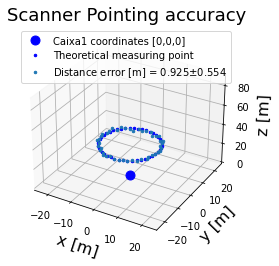

In [22]:
if flags.flag_plot_measuring_points_pattern:
    
    # Calling Scanner uncertainty to plot the graphics
    Scanner_Data1 = Lidar.optics.scanner.Uncertainty(Lidar,Atmospheric_Scenario,cts) 

    
    # Creating the figure and the axes
    fig,axs4 = plt.subplots()  
    axs4=plt.axes(projection='3d')
    
    # Plotting
    axs4.plot([Lidar.optics.scanner.origin[0]],[Lidar.optics.scanner.origin[1]],[Lidar.optics.scanner.origin[2]],'ob',label='{} coordinates [{},{},{}]'.format(Lidar.LidarID,Lidar.optics.scanner.origin[0],Lidar.optics.scanner.origin[1],Lidar.optics.scanner.origin[2]),markersize=plot_param['markersize_lidar'])
    axs4.plot(Scanner_Data1['MeasPoint_Coordinates'][0],Scanner_Data1['MeasPoint_Coordinates'][1],Scanner_Data1['MeasPoint_Coordinates'][2],plot_param['markerTheo'],markersize=plot_param['markersize'],label='Theoretical measuring point')
    axs4.plot(Scanner_Data1['NoisyMeasPoint_Coordinates'][0],Scanner_Data1['NoisyMeasPoint_Coordinates'][1],Scanner_Data1['NoisyMeasPoint_Coordinates'][2],plot_param['marker'],markersize=plot_param['markersize'],label='Distance error [m] = {0:.3g}$\pm${1:.3g}'.format(np.mean(Scanner_Data1['Simu_Mean_Distance']),np.mean(Scanner_Data1['STDV_Distance'])))
    
    # Setting labels, legend, title and axes limits:
    axs4.set_xlabel('x [m]',fontsize=plot_param['axes_label_fontsize'])#,orientation=plot_param['tick_labelrotation'])
    axs4.set_ylabel('y [m]',fontsize=plot_param['axes_label_fontsize'])#,orientation=plot_param['tick_labelrotation'])
    axs4.set_zlabel('z [m]',fontsize=plot_param['axes_label_fontsize'])
    axs4.set_title('Scanner Pointing accuracy',fontsize=plot_param['title_fontsize'])
    axs4.legend()
    axs4.set_xlim3d(plot_param['xlim'][0],plot_param['xlim'][1])
    axs4.set_ylim3d(plot_param['ylim'][0],plot_param['ylim'][1])
    axs4.set_zlim3d(plot_param['zlim'][0],plot_param['zlim'][1])

### Parameters access (dot notation):

If want to access to some parameter, follow dot notation. Let's see some examples:

*Focus distance*:

In [23]:
print(Scanner1.focus_dist)

[35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35]


Optical circulator *insertion loss*:

In [24]:
print(Optical_circulator.insertion_loss)

2.1


*Optical circulator's ID*:

In [25]:
print(Optical_circulator.Optical_CirculatorID)

OC_Yaml


In [26]:
Lidar.optics.scanner.cone_angle

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [27]:
# Cone angle for each pattern point:
print(Scanner1.cone_angle)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
